In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm

from keras.models import load_model, Model
from keras.layers import *
from keras.models import Sequential
from keras import backend as K

%matplotlib inline

Using TensorFlow backend.


# One-Dimensional Sine Wave Regression
$$f_\tau(x)=a\sin(x+b)\ ; \ \tau=(a,b)$$
which $a\sim U([0.1,5])$ and $b\sim U([0,2\pi])$. In order to train the network, we will sample a few points $x_1,x_2,\ldots,x_p\sim U([-5,5])$

Finally, our model will predict the values which minimize the loss
$$L(f)=\int_{-5}^{5}dx||f(x)-f_\tau(x)||^2$$

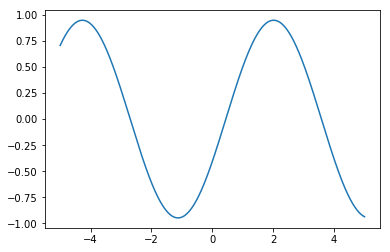

In [2]:
a = np.random.uniform(0.1, 5)
b = np.random.uniform(0, 2*np.pi)
X_plot = np.linspace(-5,5,1000)
Y = a * np.sin(X_plot + b)
plt.plot(X_plot, Y)

In [3]:
def dense_forward_norm(x,w,b, is_train, scope, norm, activation_fn=tf.nn.relu):
    h = tf.matmul(x, w) + b
    if norm:
        h = tf.contrib.layers.batch_norm(h, activation_fn=activation_fn, reuse=True, is_training=is_train)
    return h

In [4]:
def dense_forward(x,w,b, activation_fn=tf.nn.elu):
    h = tf.matmul(x, w) + b
    return activation_fn(h)

In [5]:
tf.reset_default_graph()
layers_dim = [1,64,64,1]
xavier_initializer = tf.contrib.layers.xavier_initializer()
zero_initializer = tf.zeros_initializer()
weights = [tf.get_variable('w_'+str(i), shape=layers_dim[i:i+2], initializer=xavier_initializer) for i in range(len(layers_dim) - 1)]
biases = [tf.get_variable('b_'+str(i), shape=[layers_dim[i+1]], initializer=zero_initializer) for i in range(len(layers_dim) - 1)]

In [87]:
# FOMAML

In [6]:
# MAML
UPDATED_TIMES = 32
x_train = tf.placeholder(dtype=tf.float32, shape=[None, 1])
x_val = tf.placeholder(dtype=tf.float32, shape=[None, 1])
y_train = tf.placeholder(dtype=tf.float32, shape=[None, 1])
y_val = tf.placeholder(dtype=tf.float32, shape=[None, 1])
lr1 = tf.placeholder(dtype=tf.float32)
lr2 = tf.placeholder(dtype=tf.float32)
optimizer = tf.train.AdamOptimizer(learning_rate=lr2)

new_weights = [None, None, None]
new_biases = [None, None, None]
losses_col = []
grads_col = []
for i in range(UPDATED_TIMES):
    if i == 0: # First Update
        for j in range(len(layers_dim) - 1):
            if j == 0: hidden = dense_forward(x_train, weights[j], biases[j])
            elif j == len(layers_dim) - 2: hidden = dense_forward(hidden, weights[j], biases[j], lambda x:x)
            else: hidden = dense_forward(hidden, weights[j], biases[j])
#             if j == 0: hidden = dense_forward(x_train, weights[j], biases[j], True, str(j), True)
#             elif j == len(layers_dim) - 2: hidden = dense_forward(hidden, weights[j], biases[j], True, str(j), False)
#             else: hidden = dense_forward(hidden, weights[j], biases[j], True, str(j), True)
        loss = tf.losses.mean_squared_error(y_train, hidden)
        weights_grads = tf.gradients(loss, weights)
        biases_grads = tf.gradients(loss, biases)
        for j in range(len(layers_dim) - 1):
            new_weights[j] = weights[j] - lr1 * weights_grads[j]
            new_biases[j] = biases[j] - lr1 * biases_grads[j]
        print(new_weights)
    
    else:
        for j in range(len(layers_dim) - 1):
            if j == 0: hidden = dense_forward(x_train, new_weights[j], new_biases[j])
            elif j == len(layers_dim) - 2: hidden = dense_forward(hidden, new_weights[j], new_biases[j], lambda x:x)
            else: hidden = dense_forward(hidden, new_weights[j], new_biases[j])
#             if j == 0: hidden = dense_forward(x_train, new_weights[j], new_biases[j], True, str(j), True)
#             elif j == len(layers_dim) - 2: hidden = dense_forward(hidden, new_weights[j], new_biases[j], True, str(j), False)
#             else: hidden = dense_forward(hidden, new_weights[j], new_biases[j], True, str(j), True)
        loss = tf.losses.mean_squared_error(y_train, hidden)
        weights_grads = tf.gradients(loss, new_weights)
        biases_grads = tf.gradients(loss, new_biases)
        for j in range(len(layers_dim) - 1):
            new_weights[j] = new_weights[j] - lr1 * weights_grads[j]
            new_biases[j] = new_biases[j] - lr1 * biases_grads[j]
    losses_col.append(loss)
    grads_col.append((weights_grads, biases_grads))
    
for j in range(len(layers_dim) - 1):
    if j == 0: hidden = dense_forward(x_val, new_weights[j], new_biases[j])
    elif j == len(layers_dim) - 2: hidden = dense_forward(hidden, new_weights[j], new_biases[j], lambda x:x)
    else: hidden = dense_forward(hidden, new_weights[j], new_biases[j])
        
batch_norm_updater = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
loss = tf.losses.mean_squared_error(y_val, hidden)
updater = tf.group([optimizer.minimize(loss), batch_norm_updater])

[<tf.Tensor 'sub:0' shape=<unknown> dtype=float32>, <tf.Tensor 'sub_2:0' shape=<unknown> dtype=float32>, <tf.Tensor 'sub_4:0' shape=<unknown> dtype=float32>]


In [7]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [9]:
# Training Loop
SAMPLES = 50000
X_val = np.expand_dims(np.linspace(-5,5,100), axis=-1)
loss_history = []

for i in range(SAMPLES):
    a = np.random.uniform(0.1, 5)
    b = np.random.uniform(0, 2*np.pi)
    X_train = np.random.uniform(-5,5, size=(20,1))
    Y_train = a * np.sin(X_train + b)
    Y_val = a * np.sin(X_val + b)
    feed_dict = {
        x_train: X_train,
        x_val: X_val,
        y_train: Y_train,
        y_val: Y_val,
        lr1: 1e-4,
        lr2: 5e-4    
    }
    grads, losses, _, show_loss = sess.run([grads_col, losses_col, updater, loss], feed_dict=feed_dict)
    loss_history.append(show_loss)
    print('Sample {} - loss: {}'.format(i, show_loss))

Sample 0 - loss: 4.025770664215088
Sample 1 - loss: 10.4058837890625
Sample 2 - loss: 6.911056041717529
Sample 3 - loss: 4.511169910430908
Sample 4 - loss: 0.4779472053050995
Sample 5 - loss: 7.480340957641602
Sample 6 - loss: 7.6820783615112305
Sample 7 - loss: 4.745568752288818
Sample 8 - loss: 1.6212530136108398
Sample 9 - loss: 4.528254985809326
Sample 10 - loss: 5.439282417297363
Sample 11 - loss: 12.928426742553711
Sample 12 - loss: 1.039608120918274
Sample 13 - loss: 0.6197744607925415
Sample 14 - loss: 10.613470077514648
Sample 15 - loss: 0.4884362518787384
Sample 16 - loss: 3.2884092330932617
Sample 17 - loss: 1.832098364830017
Sample 18 - loss: 2.9140164852142334
Sample 19 - loss: 11.993598937988281
Sample 20 - loss: 10.734896659851074
Sample 21 - loss: 10.455330848693848
Sample 22 - loss: 10.335461616516113
Sample 23 - loss: 1.9654393196105957
Sample 24 - loss: 6.031429290771484
Sample 25 - loss: 7.983871936798096
Sample 26 - loss: 3.098771095275879
Sample 27 - loss: 5.45032

Sample 220 - loss: 8.876261711120605
Sample 221 - loss: 9.592684745788574
Sample 222 - loss: 10.434731483459473
Sample 223 - loss: 9.432300567626953
Sample 224 - loss: 1.1498241424560547
Sample 225 - loss: 1.228346586227417
Sample 226 - loss: 4.386404991149902
Sample 227 - loss: 0.15107254683971405
Sample 228 - loss: 11.288046836853027
Sample 229 - loss: 11.138288497924805
Sample 230 - loss: 4.134504795074463
Sample 231 - loss: 10.713698387145996
Sample 232 - loss: 6.036017894744873
Sample 233 - loss: 1.178856372833252
Sample 234 - loss: 1.6559869050979614
Sample 235 - loss: 9.588109970092773
Sample 236 - loss: 1.7596697807312012
Sample 237 - loss: 7.469331741333008
Sample 238 - loss: 12.108242988586426
Sample 239 - loss: 0.13124747574329376
Sample 240 - loss: 8.007889747619629
Sample 241 - loss: 5.445522308349609
Sample 242 - loss: 0.06478976458311081
Sample 243 - loss: 6.8236165046691895
Sample 244 - loss: 0.06621713936328888
Sample 245 - loss: 9.342547416687012
Sample 246 - loss: 0.

Sample 437 - loss: 1.2954269647598267
Sample 438 - loss: 0.28917795419692993
Sample 439 - loss: 1.9442819356918335
Sample 440 - loss: 6.061319351196289
Sample 441 - loss: 1.418453335762024
Sample 442 - loss: 7.823118686676025
Sample 443 - loss: 3.8408801555633545
Sample 444 - loss: 0.8344408273696899
Sample 445 - loss: 0.12230350822210312
Sample 446 - loss: 5.483614444732666
Sample 447 - loss: 1.2492667436599731
Sample 448 - loss: 3.9824953079223633
Sample 449 - loss: 0.5234614014625549
Sample 450 - loss: 0.28176870942115784
Sample 451 - loss: 12.19175910949707
Sample 452 - loss: 1.2868835926055908
Sample 453 - loss: 9.718611717224121
Sample 454 - loss: 0.0773186907172203
Sample 455 - loss: 7.162784576416016
Sample 456 - loss: 3.2251172065734863
Sample 457 - loss: 0.13649635016918182
Sample 458 - loss: 1.6703627109527588
Sample 459 - loss: 0.529997706413269
Sample 460 - loss: 0.03181826323270798
Sample 461 - loss: 2.9124841690063477
Sample 462 - loss: 0.2852935492992401
Sample 463 - lo

Sample 654 - loss: 0.593816876411438
Sample 655 - loss: 0.09000050276517868
Sample 656 - loss: 3.9277889728546143
Sample 657 - loss: 4.601937770843506
Sample 658 - loss: 0.1147243082523346
Sample 659 - loss: 10.128118515014648
Sample 660 - loss: 0.0978892520070076
Sample 661 - loss: 3.0815536975860596
Sample 662 - loss: 0.31373974680900574
Sample 663 - loss: 1.2400479316711426
Sample 664 - loss: 0.06996770948171616
Sample 665 - loss: 1.3451950550079346
Sample 666 - loss: 0.9833320379257202
Sample 667 - loss: 1.0314875841140747
Sample 668 - loss: 0.5885624289512634
Sample 669 - loss: 0.04862635210156441
Sample 670 - loss: 0.034127820283174515
Sample 671 - loss: 0.6919209957122803
Sample 672 - loss: 0.6552355885505676
Sample 673 - loss: 0.3532414138317108
Sample 674 - loss: 1.8700320720672607
Sample 675 - loss: 0.03457893058657646
Sample 676 - loss: 6.7537689208984375
Sample 677 - loss: 2.6526131629943848
Sample 678 - loss: 1.0916333198547363
Sample 679 - loss: 0.02213135175406933
Sample

Sample 870 - loss: 10.979408264160156
Sample 871 - loss: 10.399763107299805
Sample 872 - loss: 3.3344085216522217
Sample 873 - loss: 6.928989410400391
Sample 874 - loss: 1.8729863166809082
Sample 875 - loss: 10.818105697631836
Sample 876 - loss: 9.152222633361816
Sample 877 - loss: 3.1339404582977295
Sample 878 - loss: 0.6726630926132202
Sample 879 - loss: 4.250631809234619
Sample 880 - loss: 4.226212024688721
Sample 881 - loss: 0.11669163405895233
Sample 882 - loss: 7.883131504058838
Sample 883 - loss: 2.297197103500366
Sample 884 - loss: 1.1252630949020386
Sample 885 - loss: 0.8023866415023804
Sample 886 - loss: 1.114280104637146
Sample 887 - loss: 7.8186421394348145
Sample 888 - loss: 0.12241210788488388
Sample 889 - loss: 4.5605268478393555
Sample 890 - loss: 4.308821201324463
Sample 891 - loss: 1.5644716024398804
Sample 892 - loss: 7.759820461273193
Sample 893 - loss: 0.09481365978717804
Sample 894 - loss: 4.20376443862915
Sample 895 - loss: 2.9699926376342773
Sample 896 - loss: 4

Sample 1085 - loss: 11.068643569946289
Sample 1086 - loss: 0.33241668343544006
Sample 1087 - loss: 5.403116226196289
Sample 1088 - loss: 1.3528494834899902
Sample 1089 - loss: 0.4113645851612091
Sample 1090 - loss: 2.4435079097747803
Sample 1091 - loss: 2.7240970134735107
Sample 1092 - loss: 4.622714519500732
Sample 1093 - loss: 4.961891174316406
Sample 1094 - loss: 2.2100021839141846
Sample 1095 - loss: 1.4774565696716309
Sample 1096 - loss: 10.754996299743652
Sample 1097 - loss: 9.136032104492188
Sample 1098 - loss: 9.225688934326172
Sample 1099 - loss: 2.8254711627960205
Sample 1100 - loss: 7.055125713348389
Sample 1101 - loss: 9.158773422241211
Sample 1102 - loss: 0.554445207118988
Sample 1103 - loss: 0.2695577144622803
Sample 1104 - loss: 5.11665153503418
Sample 1105 - loss: 2.253380060195923
Sample 1106 - loss: 1.4797056913375854
Sample 1107 - loss: 10.55767822265625
Sample 1108 - loss: 1.459333062171936
Sample 1109 - loss: 5.221444606781006
Sample 1110 - loss: 4.4947710037231445

Sample 1297 - loss: 2.4320921897888184
Sample 1298 - loss: 3.553309440612793
Sample 1299 - loss: 1.082969307899475
Sample 1300 - loss: 1.161039113998413
Sample 1301 - loss: 0.7574547529220581
Sample 1302 - loss: 8.933148384094238
Sample 1303 - loss: 6.5272603034973145
Sample 1304 - loss: 6.188070774078369
Sample 1305 - loss: 0.5922688841819763
Sample 1306 - loss: 6.3806586265563965
Sample 1307 - loss: 2.2181012630462646
Sample 1308 - loss: 0.6539517045021057
Sample 1309 - loss: 0.21769922971725464
Sample 1310 - loss: 0.21160516142845154
Sample 1311 - loss: 6.00286865234375
Sample 1312 - loss: 2.3660154342651367
Sample 1313 - loss: 1.4013906717300415
Sample 1314 - loss: 0.3242185115814209
Sample 1315 - loss: 0.7411477565765381
Sample 1316 - loss: 4.442996978759766
Sample 1317 - loss: 2.430950880050659
Sample 1318 - loss: 1.8359254598617554
Sample 1319 - loss: 2.5986597537994385
Sample 1320 - loss: 8.175793647766113
Sample 1321 - loss: 0.26673126220703125
Sample 1322 - loss: 0.1164977625

Sample 1508 - loss: 2.6481761932373047
Sample 1509 - loss: 0.2853509783744812
Sample 1510 - loss: 7.555361270904541
Sample 1511 - loss: 5.415019989013672
Sample 1512 - loss: 6.781798839569092
Sample 1513 - loss: 8.066425323486328
Sample 1514 - loss: 2.6477255821228027
Sample 1515 - loss: 0.6268280148506165
Sample 1516 - loss: 1.5581163167953491
Sample 1517 - loss: 3.7102301120758057
Sample 1518 - loss: 0.06601014733314514
Sample 1519 - loss: 7.451640605926514
Sample 1520 - loss: 0.07446747273206711
Sample 1521 - loss: 0.6720986366271973
Sample 1522 - loss: 0.29902705550193787
Sample 1523 - loss: 5.184765815734863
Sample 1524 - loss: 0.17273086309432983
Sample 1525 - loss: 4.090208530426025
Sample 1526 - loss: 11.356894493103027
Sample 1527 - loss: 8.491116523742676
Sample 1528 - loss: 7.6378960609436035
Sample 1529 - loss: 4.73820686340332
Sample 1530 - loss: 1.9603071212768555
Sample 1531 - loss: 6.928829193115234
Sample 1532 - loss: 0.14384281635284424
Sample 1533 - loss: 1.789251446

Sample 1719 - loss: 7.49069881439209
Sample 1720 - loss: 4.834867000579834
Sample 1721 - loss: 4.316546440124512
Sample 1722 - loss: 10.449579238891602
Sample 1723 - loss: 0.0937257707118988
Sample 1724 - loss: 0.9532036781311035
Sample 1725 - loss: 0.03810171037912369
Sample 1726 - loss: 0.021877145394682884
Sample 1727 - loss: 8.315752029418945
Sample 1728 - loss: 7.548727989196777
Sample 1729 - loss: 1.8858188390731812
Sample 1730 - loss: 0.11534395068883896
Sample 1731 - loss: 0.7976087331771851
Sample 1732 - loss: 4.270883083343506
Sample 1733 - loss: 9.780811309814453
Sample 1734 - loss: 1.7073354721069336
Sample 1735 - loss: 0.013376329094171524
Sample 1736 - loss: 8.607697486877441
Sample 1737 - loss: 2.2999508380889893
Sample 1738 - loss: 4.765040397644043
Sample 1739 - loss: 2.974398136138916
Sample 1740 - loss: 6.465885639190674
Sample 1741 - loss: 2.0288853645324707
Sample 1742 - loss: 3.2981555461883545
Sample 1743 - loss: 11.783700942993164
Sample 1744 - loss: 1.578822970

Sample 1930 - loss: 5.4095869064331055
Sample 1931 - loss: 3.7497363090515137
Sample 1932 - loss: 3.7070298194885254
Sample 1933 - loss: 7.857230186462402
Sample 1934 - loss: 7.535129547119141
Sample 1935 - loss: 8.296435356140137
Sample 1936 - loss: 4.477169036865234
Sample 1937 - loss: 0.058912526816129684
Sample 1938 - loss: 5.370750904083252
Sample 1939 - loss: 2.030932903289795
Sample 1940 - loss: 3.3806638717651367
Sample 1941 - loss: 0.17607350647449493
Sample 1942 - loss: 0.8754231929779053
Sample 1943 - loss: 2.297161102294922
Sample 1944 - loss: 0.08832790702581406
Sample 1945 - loss: 4.594562530517578
Sample 1946 - loss: 10.821863174438477
Sample 1947 - loss: 2.856387138366699
Sample 1948 - loss: 3.8506436347961426
Sample 1949 - loss: 4.4152140617370605
Sample 1950 - loss: 0.8922690749168396
Sample 1951 - loss: 1.0876455307006836
Sample 1952 - loss: 2.9242734909057617
Sample 1953 - loss: 4.170801162719727
Sample 1954 - loss: 3.594228744506836
Sample 1955 - loss: 7.0215439796

Sample 2141 - loss: 0.059026751667261124
Sample 2142 - loss: 0.7262815833091736
Sample 2143 - loss: 0.4949285089969635
Sample 2144 - loss: 0.01036472711712122
Sample 2145 - loss: 0.9822327494621277
Sample 2146 - loss: 5.341798305511475
Sample 2147 - loss: 0.017256176099181175
Sample 2148 - loss: 2.2678542137145996
Sample 2149 - loss: 7.737095355987549
Sample 2150 - loss: 11.18739128112793
Sample 2151 - loss: 1.9345884323120117
Sample 2152 - loss: 3.3845303058624268
Sample 2153 - loss: 0.2627103328704834
Sample 2154 - loss: 0.05906543880701065
Sample 2155 - loss: 0.0615750215947628
Sample 2156 - loss: 0.13462120294570923
Sample 2157 - loss: 9.616873741149902
Sample 2158 - loss: 13.110099792480469
Sample 2159 - loss: 0.16864368319511414
Sample 2160 - loss: 8.4060697555542
Sample 2161 - loss: 2.775850296020508
Sample 2162 - loss: 0.3240000605583191
Sample 2163 - loss: 3.638035535812378
Sample 2164 - loss: 6.444900989532471
Sample 2165 - loss: 2.051400899887085
Sample 2166 - loss: 0.855070

Sample 2353 - loss: 12.81308364868164
Sample 2354 - loss: 8.437860488891602
Sample 2355 - loss: 0.5440267324447632
Sample 2356 - loss: 1.0548231601715088
Sample 2357 - loss: 2.010972499847412
Sample 2358 - loss: 3.289721965789795
Sample 2359 - loss: 1.7305915355682373
Sample 2360 - loss: 3.7548882961273193
Sample 2361 - loss: 1.93720281124115
Sample 2362 - loss: 4.744126796722412
Sample 2363 - loss: 8.291250228881836
Sample 2364 - loss: 8.348125457763672
Sample 2365 - loss: 0.11641261726617813
Sample 2366 - loss: 2.7717831134796143
Sample 2367 - loss: 1.9195348024368286
Sample 2368 - loss: 0.2819198668003082
Sample 2369 - loss: 4.291763782501221
Sample 2370 - loss: 0.9385929107666016
Sample 2371 - loss: 6.286184787750244
Sample 2372 - loss: 0.42288193106651306
Sample 2373 - loss: 11.040702819824219
Sample 2374 - loss: 2.290844678878784
Sample 2375 - loss: 4.10054349899292
Sample 2376 - loss: 4.840351104736328
Sample 2377 - loss: 0.3282802104949951
Sample 2378 - loss: 0.0691768899559974

Sample 2565 - loss: 10.075042724609375
Sample 2566 - loss: 8.241927146911621
Sample 2567 - loss: 0.6015828847885132
Sample 2568 - loss: 1.6609209775924683
Sample 2569 - loss: 2.0712015628814697
Sample 2570 - loss: 5.308690071105957
Sample 2571 - loss: 5.365098476409912
Sample 2572 - loss: 2.35371470451355
Sample 2573 - loss: 7.954948902130127
Sample 2574 - loss: 6.423425197601318
Sample 2575 - loss: 5.758338451385498
Sample 2576 - loss: 0.9319648146629333
Sample 2577 - loss: 0.6982539892196655
Sample 2578 - loss: 8.511853218078613
Sample 2579 - loss: 3.5998048782348633
Sample 2580 - loss: 1.4027317762374878
Sample 2581 - loss: 2.399557590484619
Sample 2582 - loss: 5.510629177093506
Sample 2583 - loss: 9.89793872833252
Sample 2584 - loss: 0.04519004002213478
Sample 2585 - loss: 10.556002616882324
Sample 2586 - loss: 2.889773368835449
Sample 2587 - loss: 11.854623794555664
Sample 2588 - loss: 0.4883522689342499
Sample 2589 - loss: 8.351871490478516
Sample 2590 - loss: 10.250897407531738


Sample 2777 - loss: 7.882070541381836
Sample 2778 - loss: 0.3325187563896179
Sample 2779 - loss: 1.4362363815307617
Sample 2780 - loss: 2.9381978511810303
Sample 2781 - loss: 9.062932014465332
Sample 2782 - loss: 0.07662412524223328
Sample 2783 - loss: 3.2387077808380127
Sample 2784 - loss: 6.876713275909424
Sample 2785 - loss: 4.032163143157959
Sample 2786 - loss: 0.11654737591743469
Sample 2787 - loss: 1.4198861122131348
Sample 2788 - loss: 10.518380165100098
Sample 2789 - loss: 5.338935375213623
Sample 2790 - loss: 1.439542531967163
Sample 2791 - loss: 4.245683193206787
Sample 2792 - loss: 2.501201629638672
Sample 2793 - loss: 10.950133323669434
Sample 2794 - loss: 0.08368270844221115
Sample 2795 - loss: 0.4494283199310303
Sample 2796 - loss: 8.211779594421387
Sample 2797 - loss: 5.184431552886963
Sample 2798 - loss: 1.8830276727676392
Sample 2799 - loss: 0.8324276804924011
Sample 2800 - loss: 1.9836825132369995
Sample 2801 - loss: 1.7833452224731445
Sample 2802 - loss: 2.0120136737

Sample 2988 - loss: 1.7791229486465454
Sample 2989 - loss: 1.8483799695968628
Sample 2990 - loss: 7.312802791595459
Sample 2991 - loss: 4.315156936645508
Sample 2992 - loss: 2.446122169494629
Sample 2993 - loss: 0.45598679780960083
Sample 2994 - loss: 0.11847937852144241
Sample 2995 - loss: 3.515596866607666
Sample 2996 - loss: 2.2415413856506348
Sample 2997 - loss: 9.241704940795898
Sample 2998 - loss: 7.215879440307617
Sample 2999 - loss: 0.5006793737411499
Sample 3000 - loss: 1.673161268234253
Sample 3001 - loss: 1.656297206878662
Sample 3002 - loss: 5.854301929473877
Sample 3003 - loss: 0.8469058871269226
Sample 3004 - loss: 3.94610595703125
Sample 3005 - loss: 10.309545516967773
Sample 3006 - loss: 0.17207159101963043
Sample 3007 - loss: 4.312321662902832
Sample 3008 - loss: 11.266554832458496
Sample 3009 - loss: 1.6344192028045654
Sample 3010 - loss: 0.2406032234430313
Sample 3011 - loss: 8.679463386535645
Sample 3012 - loss: 1.9073989391326904
Sample 3013 - loss: 2.6287374496459

Sample 3200 - loss: 8.432062149047852
Sample 3201 - loss: 0.20589803159236908
Sample 3202 - loss: 1.8426474332809448
Sample 3203 - loss: 1.4412509202957153
Sample 3204 - loss: 8.646929740905762
Sample 3205 - loss: 4.616246700286865
Sample 3206 - loss: 4.333710193634033
Sample 3207 - loss: 1.0663855075836182
Sample 3208 - loss: 4.207803726196289
Sample 3209 - loss: 2.136035680770874
Sample 3210 - loss: 8.519187927246094
Sample 3211 - loss: 3.144345760345459
Sample 3212 - loss: 2.7862942218780518
Sample 3213 - loss: 9.050345420837402
Sample 3214 - loss: 1.549069881439209
Sample 3215 - loss: 0.00570777477696538
Sample 3216 - loss: 5.173387050628662
Sample 3217 - loss: 3.377110004425049
Sample 3218 - loss: 6.058750152587891
Sample 3219 - loss: 7.4409260749816895
Sample 3220 - loss: 3.3525989055633545
Sample 3221 - loss: 9.497699737548828
Sample 3222 - loss: 9.424042701721191
Sample 3223 - loss: 0.007267504930496216
Sample 3224 - loss: 0.646348237991333
Sample 3225 - loss: 1.173689126968383

Sample 3411 - loss: 0.11382681131362915
Sample 3412 - loss: 0.7112985253334045
Sample 3413 - loss: 10.953455924987793
Sample 3414 - loss: 3.9564919471740723
Sample 3415 - loss: 8.030448913574219
Sample 3416 - loss: 5.584470272064209
Sample 3417 - loss: 1.211750864982605
Sample 3418 - loss: 0.6026954054832458
Sample 3419 - loss: 0.9535388350486755
Sample 3420 - loss: 2.9049882888793945
Sample 3421 - loss: 3.2991690635681152
Sample 3422 - loss: 0.34674397110939026
Sample 3423 - loss: 5.204678535461426
Sample 3424 - loss: 8.794408798217773
Sample 3425 - loss: 0.47983863949775696
Sample 3426 - loss: 2.581202983856201
Sample 3427 - loss: 1.6955894231796265
Sample 3428 - loss: 3.219452142715454
Sample 3429 - loss: 0.2542212903499603
Sample 3430 - loss: 7.60023307800293
Sample 3431 - loss: 8.996635437011719
Sample 3432 - loss: 7.294495105743408
Sample 3433 - loss: 9.943129539489746
Sample 3434 - loss: 1.3922518491744995
Sample 3435 - loss: 0.4538339376449585
Sample 3436 - loss: 6.9208984375
S

Sample 3623 - loss: 1.4311249256134033
Sample 3624 - loss: 6.319538116455078
Sample 3625 - loss: 2.4812116622924805
Sample 3626 - loss: 5.951370716094971
Sample 3627 - loss: 4.537091255187988
Sample 3628 - loss: 4.725359916687012
Sample 3629 - loss: 3.1406409740448
Sample 3630 - loss: 2.817072868347168
Sample 3631 - loss: 11.810173034667969
Sample 3632 - loss: 0.333598792552948
Sample 3633 - loss: 5.789766788482666
Sample 3634 - loss: 2.9727730751037598
Sample 3635 - loss: 0.022854939103126526
Sample 3636 - loss: 0.08088592439889908
Sample 3637 - loss: 10.08651065826416
Sample 3638 - loss: 9.874399185180664
Sample 3639 - loss: 12.816479682922363
Sample 3640 - loss: 7.303825855255127
Sample 3641 - loss: 1.2003618478775024
Sample 3642 - loss: 8.72810173034668
Sample 3643 - loss: 10.626258850097656
Sample 3644 - loss: 0.06929139792919159
Sample 3645 - loss: 4.818211555480957
Sample 3646 - loss: 2.3088197708129883
Sample 3647 - loss: 5.7409772872924805
Sample 3648 - loss: 4.624357223510742

Sample 3834 - loss: 7.153131008148193
Sample 3835 - loss: 6.535870552062988
Sample 3836 - loss: 4.146636486053467
Sample 3837 - loss: 3.353799343109131
Sample 3838 - loss: 7.413211822509766
Sample 3839 - loss: 6.216334819793701
Sample 3840 - loss: 0.5284578204154968
Sample 3841 - loss: 10.160179138183594
Sample 3842 - loss: 5.785253524780273
Sample 3843 - loss: 1.2062947750091553
Sample 3844 - loss: 0.32505160570144653
Sample 3845 - loss: 0.4541217088699341
Sample 3846 - loss: 0.8187351822853088
Sample 3847 - loss: 1.3752719163894653
Sample 3848 - loss: 2.0726795196533203
Sample 3849 - loss: 10.20010757446289
Sample 3850 - loss: 0.05434080585837364
Sample 3851 - loss: 7.303867340087891
Sample 3852 - loss: 3.8859283924102783
Sample 3853 - loss: 0.011275810189545155
Sample 3854 - loss: 5.416107654571533
Sample 3855 - loss: 2.737711191177368
Sample 3856 - loss: 3.8250656127929688
Sample 3857 - loss: 0.16035732626914978
Sample 3858 - loss: 7.692571640014648
Sample 3859 - loss: 6.6597785949

Sample 4045 - loss: 1.0687036514282227
Sample 4046 - loss: 2.3035295009613037
Sample 4047 - loss: 6.2545952796936035
Sample 4048 - loss: 8.908413887023926
Sample 4049 - loss: 5.166697978973389
Sample 4050 - loss: 0.051007285714149475
Sample 4051 - loss: 8.180925369262695
Sample 4052 - loss: 10.111732482910156
Sample 4053 - loss: 3.4163637161254883
Sample 4054 - loss: 9.332098960876465
Sample 4055 - loss: 0.27916252613067627
Sample 4056 - loss: 1.8431525230407715
Sample 4057 - loss: 7.812733173370361
Sample 4058 - loss: 0.6230649948120117
Sample 4059 - loss: 1.4117393493652344
Sample 4060 - loss: 2.575976610183716
Sample 4061 - loss: 3.5316171646118164
Sample 4062 - loss: 0.004214094486087561
Sample 4063 - loss: 6.002302169799805
Sample 4064 - loss: 1.6506630182266235
Sample 4065 - loss: 3.3012783527374268
Sample 4066 - loss: 4.2468037605285645
Sample 4067 - loss: 1.0208579301834106
Sample 4068 - loss: 10.738338470458984
Sample 4069 - loss: 2.312020778656006
Sample 4070 - loss: 4.647039

Sample 4257 - loss: 6.7459588050842285
Sample 4258 - loss: 0.1206272542476654
Sample 4259 - loss: 2.7022805213928223
Sample 4260 - loss: 0.5254570245742798
Sample 4261 - loss: 1.4586354494094849
Sample 4262 - loss: 1.5905463695526123
Sample 4263 - loss: 2.4355368614196777
Sample 4264 - loss: 12.190150260925293
Sample 4265 - loss: 8.787059783935547
Sample 4266 - loss: 3.856740951538086
Sample 4267 - loss: 4.7934160232543945
Sample 4268 - loss: 0.1358686089515686
Sample 4269 - loss: 7.879392623901367
Sample 4270 - loss: 4.837490558624268
Sample 4271 - loss: 6.985787391662598
Sample 4272 - loss: 0.3430827260017395
Sample 4273 - loss: 7.112232208251953
Sample 4274 - loss: 6.755774021148682
Sample 4275 - loss: 9.304899215698242
Sample 4276 - loss: 8.200469017028809
Sample 4277 - loss: 2.4986438751220703
Sample 4278 - loss: 3.1388604640960693
Sample 4279 - loss: 4.804966926574707
Sample 4280 - loss: 10.428911209106445
Sample 4281 - loss: 2.516693353652954
Sample 4282 - loss: 3.44893026351928

Sample 4469 - loss: 8.591131210327148
Sample 4470 - loss: 3.1733603477478027
Sample 4471 - loss: 1.9705047607421875
Sample 4472 - loss: 1.805019497871399
Sample 4473 - loss: 3.0387766361236572
Sample 4474 - loss: 3.6187212467193604
Sample 4475 - loss: 5.472872734069824
Sample 4476 - loss: 1.3364681005477905
Sample 4477 - loss: 5.124298095703125
Sample 4478 - loss: 3.9620308876037598
Sample 4479 - loss: 6.970833778381348
Sample 4480 - loss: 6.897891998291016
Sample 4481 - loss: 10.954527854919434
Sample 4482 - loss: 0.20973622798919678
Sample 4483 - loss: 3.9302971363067627
Sample 4484 - loss: 0.33638301491737366
Sample 4485 - loss: 4.084356307983398
Sample 4486 - loss: 1.5752676725387573
Sample 4487 - loss: 1.2354702949523926
Sample 4488 - loss: 7.284114837646484
Sample 4489 - loss: 1.9619698524475098
Sample 4490 - loss: 6.573225498199463
Sample 4491 - loss: 0.07977414131164551
Sample 4492 - loss: 9.391361236572266
Sample 4493 - loss: 1.8608012199401855
Sample 4494 - loss: 0.6255764961

Sample 4681 - loss: 1.0324751138687134
Sample 4682 - loss: 11.994906425476074
Sample 4683 - loss: 5.603574275970459
Sample 4684 - loss: 2.6805810928344727
Sample 4685 - loss: 4.386209011077881
Sample 4686 - loss: 6.880972385406494
Sample 4687 - loss: 1.9247384071350098
Sample 4688 - loss: 0.27281367778778076
Sample 4689 - loss: 3.7550971508026123
Sample 4690 - loss: 0.3070908188819885
Sample 4691 - loss: 3.741748094558716
Sample 4692 - loss: 0.02123847045004368
Sample 4693 - loss: 5.604673862457275
Sample 4694 - loss: 9.716096878051758
Sample 4695 - loss: 8.028404235839844
Sample 4696 - loss: 0.24718298017978668
Sample 4697 - loss: 0.09837773442268372
Sample 4698 - loss: 3.7818443775177
Sample 4699 - loss: 3.2760848999023438
Sample 4700 - loss: 6.407706260681152
Sample 4701 - loss: 0.540244460105896
Sample 4702 - loss: 9.935452461242676
Sample 4703 - loss: 9.126382827758789
Sample 4704 - loss: 0.25993624329566956
Sample 4705 - loss: 0.159904345870018
Sample 4706 - loss: 8.0647039413452

Sample 4893 - loss: 10.466452598571777
Sample 4894 - loss: 4.8518595695495605
Sample 4895 - loss: 0.00663940841332078
Sample 4896 - loss: 0.3595995306968689
Sample 4897 - loss: 1.8875802755355835
Sample 4898 - loss: 9.502470970153809
Sample 4899 - loss: 6.642879486083984
Sample 4900 - loss: 8.258591651916504
Sample 4901 - loss: 4.4063310623168945
Sample 4902 - loss: 3.0123283863067627
Sample 4903 - loss: 0.5805777907371521
Sample 4904 - loss: 1.0715360641479492
Sample 4905 - loss: 0.9255664944648743
Sample 4906 - loss: 1.9122772216796875
Sample 4907 - loss: 1.4724208116531372
Sample 4908 - loss: 2.2300870418548584
Sample 4909 - loss: 1.6163992881774902
Sample 4910 - loss: 0.9911460876464844
Sample 4911 - loss: 4.368727207183838
Sample 4912 - loss: 3.615736484527588
Sample 4913 - loss: 1.6412221193313599
Sample 4914 - loss: 2.3103837966918945
Sample 4915 - loss: 7.203245162963867
Sample 4916 - loss: 7.88437557220459
Sample 4917 - loss: 9.605520248413086
Sample 4918 - loss: 6.17538833618

Sample 5104 - loss: 6.572513580322266
Sample 5105 - loss: 0.055528245866298676
Sample 5106 - loss: 2.2783727645874023
Sample 5107 - loss: 0.19379331171512604
Sample 5108 - loss: 3.097846269607544
Sample 5109 - loss: 8.601415634155273
Sample 5110 - loss: 2.675567626953125
Sample 5111 - loss: 4.185522079467773
Sample 5112 - loss: 0.9262771606445312
Sample 5113 - loss: 5.082454204559326
Sample 5114 - loss: 0.014899704605340958
Sample 5115 - loss: 1.39430832862854
Sample 5116 - loss: 0.005892076063901186
Sample 5117 - loss: 2.5189788341522217
Sample 5118 - loss: 0.018742546439170837
Sample 5119 - loss: 5.07783317565918
Sample 5120 - loss: 4.5914716720581055
Sample 5121 - loss: 2.0081818103790283
Sample 5122 - loss: 4.406399726867676
Sample 5123 - loss: 0.7784122228622437
Sample 5124 - loss: 4.551477432250977
Sample 5125 - loss: 3.210819959640503
Sample 5126 - loss: 5.837759017944336
Sample 5127 - loss: 3.0024094581604004
Sample 5128 - loss: 7.888181686401367
Sample 5129 - loss: 5.077738761

Sample 5315 - loss: 0.8345180749893188
Sample 5316 - loss: 7.977790355682373
Sample 5317 - loss: 2.0240509510040283
Sample 5318 - loss: 2.8973233699798584
Sample 5319 - loss: 2.573604106903076
Sample 5320 - loss: 6.010766983032227
Sample 5321 - loss: 9.218350410461426
Sample 5322 - loss: 0.8353510499000549
Sample 5323 - loss: 0.03726212680339813
Sample 5324 - loss: 8.243829727172852
Sample 5325 - loss: 7.123327732086182
Sample 5326 - loss: 10.22097396850586
Sample 5327 - loss: 8.113306045532227
Sample 5328 - loss: 3.7648072242736816
Sample 5329 - loss: 0.9714291095733643
Sample 5330 - loss: 1.1021466255187988
Sample 5331 - loss: 8.477795600891113
Sample 5332 - loss: 3.033973455429077
Sample 5333 - loss: 3.940758466720581
Sample 5334 - loss: 7.135009765625
Sample 5335 - loss: 4.540177822113037
Sample 5336 - loss: 12.564627647399902
Sample 5337 - loss: 1.0442326068878174
Sample 5338 - loss: 5.0832438468933105
Sample 5339 - loss: 8.776715278625488
Sample 5340 - loss: 1.8930624723434448
Sa

Sample 5527 - loss: 2.870400905609131
Sample 5528 - loss: 2.4637513160705566
Sample 5529 - loss: 0.9164065718650818
Sample 5530 - loss: 0.8993694186210632
Sample 5531 - loss: 2.349175453186035
Sample 5532 - loss: 0.45569390058517456
Sample 5533 - loss: 1.303676962852478
Sample 5534 - loss: 8.415765762329102
Sample 5535 - loss: 1.2821182012557983
Sample 5536 - loss: 9.233075141906738
Sample 5537 - loss: 4.807704448699951
Sample 5538 - loss: 0.7387658953666687
Sample 5539 - loss: 0.7003464698791504
Sample 5540 - loss: 0.0247283224016428
Sample 5541 - loss: 8.901518821716309
Sample 5542 - loss: 3.224133014678955
Sample 5543 - loss: 6.1763834953308105
Sample 5544 - loss: 4.426570892333984
Sample 5545 - loss: 5.857046127319336
Sample 5546 - loss: 2.395172595977783
Sample 5547 - loss: 2.957939863204956
Sample 5548 - loss: 4.583652019500732
Sample 5549 - loss: 4.720492362976074
Sample 5550 - loss: 7.076227188110352
Sample 5551 - loss: 7.123837471008301
Sample 5552 - loss: 4.764825344085693
Sa

Sample 5738 - loss: 5.843545436859131
Sample 5739 - loss: 0.03253998979926109
Sample 5740 - loss: 4.169116497039795
Sample 5741 - loss: 6.421796798706055
Sample 5742 - loss: 5.938923358917236
Sample 5743 - loss: 6.326956272125244
Sample 5744 - loss: 0.2206084132194519
Sample 5745 - loss: 2.783669948577881
Sample 5746 - loss: 0.16407173871994019
Sample 5747 - loss: 0.07314667105674744
Sample 5748 - loss: 0.027557983994483948
Sample 5749 - loss: 0.4871169626712799
Sample 5750 - loss: 8.027320861816406
Sample 5751 - loss: 4.027993679046631
Sample 5752 - loss: 3.0316879749298096
Sample 5753 - loss: 7.045910835266113
Sample 5754 - loss: 6.168893814086914
Sample 5755 - loss: 1.9206167459487915
Sample 5756 - loss: 2.3618791103363037
Sample 5757 - loss: 2.748175859451294
Sample 5758 - loss: 0.6562262177467346
Sample 5759 - loss: 1.561012625694275
Sample 5760 - loss: 0.1508428454399109
Sample 5761 - loss: 0.3396809697151184
Sample 5762 - loss: 3.8949596881866455
Sample 5763 - loss: 3.0285310745

Sample 5949 - loss: 0.8391338586807251
Sample 5950 - loss: 4.818227291107178
Sample 5951 - loss: 1.975576639175415
Sample 5952 - loss: 1.7233381271362305
Sample 5953 - loss: 0.934814453125
Sample 5954 - loss: 4.505177974700928
Sample 5955 - loss: 0.6101803183555603
Sample 5956 - loss: 3.6364614963531494
Sample 5957 - loss: 0.023012211546301842
Sample 5958 - loss: 3.1864876747131348
Sample 5959 - loss: 0.8737567067146301
Sample 5960 - loss: 2.0507214069366455
Sample 5961 - loss: 0.6573230624198914
Sample 5962 - loss: 0.16941837966442108
Sample 5963 - loss: 0.1344711184501648
Sample 5964 - loss: 0.1421806365251541
Sample 5965 - loss: 0.018760301172733307
Sample 5966 - loss: 2.738372802734375
Sample 5967 - loss: 0.11331071704626083
Sample 5968 - loss: 0.22058242559432983
Sample 5969 - loss: 0.2273339331150055
Sample 5970 - loss: 0.39632147550582886
Sample 5971 - loss: 6.38840389251709
Sample 5972 - loss: 1.245241641998291
Sample 5973 - loss: 6.994623184204102
Sample 5974 - loss: 3.9154920

Sample 6160 - loss: 4.699068069458008
Sample 6161 - loss: 1.8439559936523438
Sample 6162 - loss: 4.408613681793213
Sample 6163 - loss: 0.08099689334630966
Sample 6164 - loss: 8.734045028686523
Sample 6165 - loss: 0.1656321883201599
Sample 6166 - loss: 6.717243671417236
Sample 6167 - loss: 1.2370480298995972
Sample 6168 - loss: 0.3578942120075226
Sample 6169 - loss: 0.8529826998710632
Sample 6170 - loss: 6.104450702667236
Sample 6171 - loss: 4.089847564697266
Sample 6172 - loss: 0.8595786094665527
Sample 6173 - loss: 0.15639819204807281
Sample 6174 - loss: 0.08574599027633667
Sample 6175 - loss: 2.1244924068450928
Sample 6176 - loss: 6.812766075134277
Sample 6177 - loss: 0.5391920804977417
Sample 6178 - loss: 3.4915921688079834
Sample 6179 - loss: 1.6671936511993408
Sample 6180 - loss: 0.8543413281440735
Sample 6181 - loss: 4.600345611572266
Sample 6182 - loss: 0.08376138657331467
Sample 6183 - loss: 1.203601360321045
Sample 6184 - loss: 0.3049080967903137
Sample 6185 - loss: 0.22909879

Sample 6371 - loss: 0.4935416281223297
Sample 6372 - loss: 4.6493611335754395
Sample 6373 - loss: 7.753335475921631
Sample 6374 - loss: 0.540151834487915
Sample 6375 - loss: 6.98179817199707
Sample 6376 - loss: 0.6876477599143982
Sample 6377 - loss: 0.5841436982154846
Sample 6378 - loss: 0.38821351528167725
Sample 6379 - loss: 0.32125940918922424
Sample 6380 - loss: 6.422905445098877
Sample 6381 - loss: 1.8763600587844849
Sample 6382 - loss: 1.7021081447601318
Sample 6383 - loss: 0.054112508893013
Sample 6384 - loss: 2.7864084243774414
Sample 6385 - loss: 1.9277223348617554
Sample 6386 - loss: 6.767810821533203
Sample 6387 - loss: 0.6654064059257507
Sample 6388 - loss: 1.3835369348526
Sample 6389 - loss: 1.4049800634384155
Sample 6390 - loss: 8.050588607788086
Sample 6391 - loss: 5.412259578704834
Sample 6392 - loss: 0.5070671439170837
Sample 6393 - loss: 1.7240105867385864
Sample 6394 - loss: 0.6082732677459717
Sample 6395 - loss: 0.7592970132827759
Sample 6396 - loss: 6.3302783966064

Sample 6582 - loss: 4.063327312469482
Sample 6583 - loss: 1.6529258489608765
Sample 6584 - loss: 0.17630231380462646
Sample 6585 - loss: 8.736261367797852
Sample 6586 - loss: 3.7759737968444824
Sample 6587 - loss: 7.75344181060791
Sample 6588 - loss: 6.102630138397217
Sample 6589 - loss: 7.519289016723633
Sample 6590 - loss: 0.5181826949119568
Sample 6591 - loss: 5.508260726928711
Sample 6592 - loss: 1.0952216386795044
Sample 6593 - loss: 0.7977900505065918
Sample 6594 - loss: 7.589993953704834
Sample 6595 - loss: 1.0574527978897095
Sample 6596 - loss: 6.091337203979492
Sample 6597 - loss: 7.63702392578125
Sample 6598 - loss: 4.1278300285339355
Sample 6599 - loss: 4.83108377456665
Sample 6600 - loss: 1.0756878852844238
Sample 6601 - loss: 6.016512870788574
Sample 6602 - loss: 2.1697380542755127
Sample 6603 - loss: 4.772522926330566
Sample 6604 - loss: 2.633612871170044
Sample 6605 - loss: 3.20204496383667
Sample 6606 - loss: 7.727748870849609
Sample 6607 - loss: 6.419852256774902
Sampl

Sample 6793 - loss: 0.37505072355270386
Sample 6794 - loss: 1.7827948331832886
Sample 6795 - loss: 8.422574043273926
Sample 6796 - loss: 7.862325668334961
Sample 6797 - loss: 0.3479045629501343
Sample 6798 - loss: 2.7018191814422607
Sample 6799 - loss: 3.4924585819244385
Sample 6800 - loss: 2.051316022872925
Sample 6801 - loss: 0.7426549792289734
Sample 6802 - loss: 0.6731424927711487
Sample 6803 - loss: 4.345933437347412
Sample 6804 - loss: 1.8931634426116943
Sample 6805 - loss: 6.810971736907959
Sample 6806 - loss: 5.1638312339782715
Sample 6807 - loss: 0.10024340450763702
Sample 6808 - loss: 2.2381386756896973
Sample 6809 - loss: 1.9146801233291626
Sample 6810 - loss: 0.7259458899497986
Sample 6811 - loss: 8.212409019470215
Sample 6812 - loss: 9.303218841552734
Sample 6813 - loss: 3.0169544219970703
Sample 6814 - loss: 6.643243789672852
Sample 6815 - loss: 5.545319080352783
Sample 6816 - loss: 3.67012095451355
Sample 6817 - loss: 4.846198558807373
Sample 6818 - loss: 6.2946467399597

Sample 7004 - loss: 0.5127984881401062
Sample 7005 - loss: 6.711535453796387
Sample 7006 - loss: 0.8395031690597534
Sample 7007 - loss: 4.871967792510986
Sample 7008 - loss: 3.896951913833618
Sample 7009 - loss: 7.172264575958252
Sample 7010 - loss: 3.4696249961853027
Sample 7011 - loss: 4.125284671783447
Sample 7012 - loss: 2.6015126705169678
Sample 7013 - loss: 0.34061935544013977
Sample 7014 - loss: 7.342222213745117
Sample 7015 - loss: 2.3811614513397217
Sample 7016 - loss: 6.111218452453613
Sample 7017 - loss: 4.604427337646484
Sample 7018 - loss: 0.11081399768590927
Sample 7019 - loss: 0.29640698432922363
Sample 7020 - loss: 6.273463726043701
Sample 7021 - loss: 3.3217544555664062
Sample 7022 - loss: 0.32511797547340393
Sample 7023 - loss: 1.2690341472625732
Sample 7024 - loss: 1.5152745246887207
Sample 7025 - loss: 2.273024559020996
Sample 7026 - loss: 0.018933916464447975
Sample 7027 - loss: 7.649655818939209
Sample 7028 - loss: 4.724937915802002
Sample 7029 - loss: 1.488673686

Sample 7215 - loss: 0.020446471869945526
Sample 7216 - loss: 0.6648706197738647
Sample 7217 - loss: 1.4122650623321533
Sample 7218 - loss: 2.398831844329834
Sample 7219 - loss: 2.971567153930664
Sample 7220 - loss: 0.34016817808151245
Sample 7221 - loss: 1.8607535362243652
Sample 7222 - loss: 5.627710342407227
Sample 7223 - loss: 4.669456958770752
Sample 7224 - loss: 3.6321682929992676
Sample 7225 - loss: 3.8718392848968506
Sample 7226 - loss: 5.807623386383057
Sample 7227 - loss: 7.973222255706787
Sample 7228 - loss: 1.8269104957580566
Sample 7229 - loss: 0.4198939800262451
Sample 7230 - loss: 6.430382251739502
Sample 7231 - loss: 0.2417396903038025
Sample 7232 - loss: 1.7120262384414673
Sample 7233 - loss: 0.3943796455860138
Sample 7234 - loss: 0.6122217178344727
Sample 7235 - loss: 2.5358221530914307
Sample 7236 - loss: 0.18959398567676544
Sample 7237 - loss: 2.2781741619110107
Sample 7238 - loss: 7.279443740844727
Sample 7239 - loss: 5.787117958068848
Sample 7240 - loss: 1.79867923

Sample 7426 - loss: 10.148890495300293
Sample 7427 - loss: 0.24114403128623962
Sample 7428 - loss: 3.592808723449707
Sample 7429 - loss: 0.12138788402080536
Sample 7430 - loss: 4.853419303894043
Sample 7431 - loss: 0.15714238584041595
Sample 7432 - loss: 4.9874348640441895
Sample 7433 - loss: 6.792701244354248
Sample 7434 - loss: 0.5724468231201172
Sample 7435 - loss: 1.0256741046905518
Sample 7436 - loss: 0.2183333784341812
Sample 7437 - loss: 2.442370653152466
Sample 7438 - loss: 1.1528509855270386
Sample 7439 - loss: 5.034995079040527
Sample 7440 - loss: 1.675644040107727
Sample 7441 - loss: 0.5447024703025818
Sample 7442 - loss: 0.022357024252414703
Sample 7443 - loss: 1.6168354749679565
Sample 7444 - loss: 5.288761138916016
Sample 7445 - loss: 0.04617730528116226
Sample 7446 - loss: 6.873814582824707
Sample 7447 - loss: 5.302468776702881
Sample 7448 - loss: 0.03538895025849342
Sample 7449 - loss: 0.263848215341568
Sample 7450 - loss: 2.427816390991211
Sample 7451 - loss: 0.1465363

Sample 7637 - loss: 0.6931155920028687
Sample 7638 - loss: 6.364226818084717
Sample 7639 - loss: 1.4250906705856323
Sample 7640 - loss: 0.6502219438552856
Sample 7641 - loss: 1.7403825521469116
Sample 7642 - loss: 1.9108538627624512
Sample 7643 - loss: 0.7660821676254272
Sample 7644 - loss: 0.12011577934026718
Sample 7645 - loss: 0.4319108724594116
Sample 7646 - loss: 0.05707906186580658
Sample 7647 - loss: 5.8295578956604
Sample 7648 - loss: 2.014930009841919
Sample 7649 - loss: 7.030427932739258
Sample 7650 - loss: 1.6259466409683228
Sample 7651 - loss: 0.03684961423277855
Sample 7652 - loss: 8.05398178100586
Sample 7653 - loss: 3.0450210571289062
Sample 7654 - loss: 1.8405598402023315
Sample 7655 - loss: 8.020086288452148
Sample 7656 - loss: 1.31703519821167
Sample 7657 - loss: 1.8908308744430542
Sample 7658 - loss: 4.233496189117432
Sample 7659 - loss: 0.10284430533647537
Sample 7660 - loss: 1.8607685565948486
Sample 7661 - loss: 2.5014760494232178
Sample 7662 - loss: 1.16472637653

Sample 7848 - loss: 0.4983004033565521
Sample 7849 - loss: 0.05257473140954971
Sample 7850 - loss: 5.4861555099487305
Sample 7851 - loss: 1.6360907554626465
Sample 7852 - loss: 3.2914159297943115
Sample 7853 - loss: 0.010601806454360485
Sample 7854 - loss: 0.07387132942676544
Sample 7855 - loss: 3.5210137367248535
Sample 7856 - loss: 0.12247908860445023
Sample 7857 - loss: 4.971039295196533
Sample 7858 - loss: 6.443819046020508
Sample 7859 - loss: 5.559747219085693
Sample 7860 - loss: 2.105055809020996
Sample 7861 - loss: 3.6331522464752197
Sample 7862 - loss: 3.503218650817871
Sample 7863 - loss: 2.2509987354278564
Sample 7864 - loss: 0.41787204146385193
Sample 7865 - loss: 3.524043083190918
Sample 7866 - loss: 3.692451238632202
Sample 7867 - loss: 0.4744299054145813
Sample 7868 - loss: 0.4173499345779419
Sample 7869 - loss: 6.0853376388549805
Sample 7870 - loss: 2.1867573261260986
Sample 7871 - loss: 0.5206272602081299
Sample 7872 - loss: 2.634808301925659
Sample 7873 - loss: 1.71111

Sample 8059 - loss: 0.3295906186103821
Sample 8060 - loss: 0.3625878393650055
Sample 8061 - loss: 2.0794317722320557
Sample 8062 - loss: 2.417712926864624
Sample 8063 - loss: 0.657555341720581
Sample 8064 - loss: 6.686278820037842
Sample 8065 - loss: 2.287827491760254
Sample 8066 - loss: 0.33465245366096497
Sample 8067 - loss: 5.541484355926514
Sample 8068 - loss: 0.7618240118026733
Sample 8069 - loss: 2.0921621322631836
Sample 8070 - loss: 7.782907485961914
Sample 8071 - loss: 2.5882885456085205
Sample 8072 - loss: 0.7662693858146667
Sample 8073 - loss: 7.554283618927002
Sample 8074 - loss: 3.0916223526000977
Sample 8075 - loss: 3.921436071395874
Sample 8076 - loss: 0.13974638283252716
Sample 8077 - loss: 5.269267559051514
Sample 8078 - loss: 1.9212919473648071
Sample 8079 - loss: 4.161238193511963
Sample 8080 - loss: 1.4242143630981445
Sample 8081 - loss: 1.3956292867660522
Sample 8082 - loss: 2.5151641368865967
Sample 8083 - loss: 4.120306015014648
Sample 8084 - loss: 0.098754465579

Sample 8269 - loss: 2.54818058013916
Sample 8270 - loss: 0.8311103582382202
Sample 8271 - loss: 0.08528761565685272
Sample 8272 - loss: 0.42671722173690796
Sample 8273 - loss: 0.06941768527030945
Sample 8274 - loss: 0.34247416257858276
Sample 8275 - loss: 0.4515191614627838
Sample 8276 - loss: 1.0214124917984009
Sample 8277 - loss: 4.312208652496338
Sample 8278 - loss: 1.8690780401229858
Sample 8279 - loss: 2.0397744178771973
Sample 8280 - loss: 1.3447754383087158
Sample 8281 - loss: 1.715692162513733
Sample 8282 - loss: 2.5771994590759277
Sample 8283 - loss: 2.090031862258911
Sample 8284 - loss: 0.06331396102905273
Sample 8285 - loss: 0.9872279167175293
Sample 8286 - loss: 1.5125125646591187
Sample 8287 - loss: 0.049215249717235565
Sample 8288 - loss: 0.3000708818435669
Sample 8289 - loss: 1.086287498474121
Sample 8290 - loss: 1.6740645170211792
Sample 8291 - loss: 1.790956735610962
Sample 8292 - loss: 3.1275668144226074
Sample 8293 - loss: 1.919734239578247
Sample 8294 - loss: 3.0784

Sample 8479 - loss: 0.5680900812149048
Sample 8480 - loss: 1.413432002067566
Sample 8481 - loss: 3.5736310482025146
Sample 8482 - loss: 1.5217911005020142
Sample 8483 - loss: 8.3735990524292
Sample 8484 - loss: 4.599959850311279
Sample 8485 - loss: 0.7080740332603455
Sample 8486 - loss: 0.20540541410446167
Sample 8487 - loss: 0.5797693729400635
Sample 8488 - loss: 0.9565791487693787
Sample 8489 - loss: 1.363558053970337
Sample 8490 - loss: 0.9986569881439209
Sample 8491 - loss: 5.284965991973877
Sample 8492 - loss: 2.112600803375244
Sample 8493 - loss: 1.2103890180587769
Sample 8494 - loss: 2.425269365310669
Sample 8495 - loss: 0.5171712040901184
Sample 8496 - loss: 6.632695198059082
Sample 8497 - loss: 2.5648109912872314
Sample 8498 - loss: 5.896154403686523
Sample 8499 - loss: 4.388968467712402
Sample 8500 - loss: 1.2723379135131836
Sample 8501 - loss: 3.3640823364257812
Sample 8502 - loss: 4.386051654815674
Sample 8503 - loss: 0.023210696876049042
Sample 8504 - loss: 0.2747481167316

Sample 8689 - loss: 4.639659404754639
Sample 8690 - loss: 2.7558813095092773
Sample 8691 - loss: 0.03881509602069855
Sample 8692 - loss: 0.771626889705658
Sample 8693 - loss: 0.24683137238025665
Sample 8694 - loss: 1.091058373451233
Sample 8695 - loss: 3.736579179763794
Sample 8696 - loss: 0.25325703620910645
Sample 8697 - loss: 0.13690868020057678
Sample 8698 - loss: 4.951959609985352
Sample 8699 - loss: 1.9790366888046265
Sample 8700 - loss: 3.7016539573669434
Sample 8701 - loss: 3.524935007095337
Sample 8702 - loss: 3.7170026302337646
Sample 8703 - loss: 5.44577693939209
Sample 8704 - loss: 1.4753588438034058
Sample 8705 - loss: 0.23167158663272858
Sample 8706 - loss: 0.19958944618701935
Sample 8707 - loss: 0.9758987426757812
Sample 8708 - loss: 7.406884670257568
Sample 8709 - loss: 0.20108799636363983
Sample 8710 - loss: 2.6971044540405273
Sample 8711 - loss: 1.5964993238449097
Sample 8712 - loss: 0.5897542238235474
Sample 8713 - loss: 0.6538996696472168
Sample 8714 - loss: 0.00678

Sample 8899 - loss: 0.013633770868182182
Sample 8900 - loss: 0.0715101808309555
Sample 8901 - loss: 4.914303302764893
Sample 8902 - loss: 1.7362884283065796
Sample 8903 - loss: 0.28464993834495544
Sample 8904 - loss: 3.5152428150177
Sample 8905 - loss: 4.722088813781738
Sample 8906 - loss: 1.9884788990020752
Sample 8907 - loss: 0.49971023201942444
Sample 8908 - loss: 0.5829059481620789
Sample 8909 - loss: 2.659088373184204
Sample 8910 - loss: 3.581036329269409
Sample 8911 - loss: 1.067683219909668
Sample 8912 - loss: 1.219698190689087
Sample 8913 - loss: 3.6500895023345947
Sample 8914 - loss: 0.8535771369934082
Sample 8915 - loss: 0.07236852496862411
Sample 8916 - loss: 0.1014934703707695
Sample 8917 - loss: 4.948268413543701
Sample 8918 - loss: 0.08689752221107483
Sample 8919 - loss: 2.0585880279541016
Sample 8920 - loss: 0.37430086731910706
Sample 8921 - loss: 0.940549910068512
Sample 8922 - loss: 3.0277493000030518
Sample 8923 - loss: 3.3082244396209717
Sample 8924 - loss: 0.7271867

Sample 9109 - loss: 3.9807801246643066
Sample 9110 - loss: 0.8311174511909485
Sample 9111 - loss: 2.5792605876922607
Sample 9112 - loss: 0.8215724229812622
Sample 9113 - loss: 2.9871749877929688
Sample 9114 - loss: 0.034913524985313416
Sample 9115 - loss: 3.1074352264404297
Sample 9116 - loss: 1.9495333433151245
Sample 9117 - loss: 0.4119071066379547
Sample 9118 - loss: 2.114556312561035
Sample 9119 - loss: 0.3326568901538849
Sample 9120 - loss: 1.1940693855285645
Sample 9121 - loss: 0.2371469885110855
Sample 9122 - loss: 1.6286715269088745
Sample 9123 - loss: 2.027831792831421
Sample 9124 - loss: 1.2475298643112183
Sample 9125 - loss: 2.463792562484741
Sample 9126 - loss: 0.7131487131118774
Sample 9127 - loss: 1.5290191173553467
Sample 9128 - loss: 0.4687136113643646
Sample 9129 - loss: 1.9345327615737915
Sample 9130 - loss: 2.139918804168701
Sample 9131 - loss: 1.1418659687042236
Sample 9132 - loss: 4.878259181976318
Sample 9133 - loss: 0.33296898007392883
Sample 9134 - loss: 5.68933

Sample 9319 - loss: 4.203414440155029
Sample 9320 - loss: 3.9022557735443115
Sample 9321 - loss: 0.05890766158699989
Sample 9322 - loss: 0.2931261956691742
Sample 9323 - loss: 0.03327822685241699
Sample 9324 - loss: 3.0871429443359375
Sample 9325 - loss: 0.4106058180332184
Sample 9326 - loss: 0.16351330280303955
Sample 9327 - loss: 0.4252275824546814
Sample 9328 - loss: 1.4564770460128784
Sample 9329 - loss: 1.8636221885681152
Sample 9330 - loss: 3.263662099838257
Sample 9331 - loss: 1.4554028511047363
Sample 9332 - loss: 3.547023296356201
Sample 9333 - loss: 0.03353949263691902
Sample 9334 - loss: 2.03304386138916
Sample 9335 - loss: 0.042210813611745834
Sample 9336 - loss: 1.6112010478973389
Sample 9337 - loss: 2.3222475051879883
Sample 9338 - loss: 0.38071736693382263
Sample 9339 - loss: 1.3094604015350342
Sample 9340 - loss: 0.36368435621261597
Sample 9341 - loss: 0.8859326243400574
Sample 9342 - loss: 0.011986255645751953
Sample 9343 - loss: 5.154790878295898
Sample 9344 - loss: 6

Sample 9529 - loss: 1.6383700370788574
Sample 9530 - loss: 4.289965629577637
Sample 9531 - loss: 4.154896259307861
Sample 9532 - loss: 0.006832418031990528
Sample 9533 - loss: 0.11893346160650253
Sample 9534 - loss: 0.0540180578827858
Sample 9535 - loss: 0.592068076133728
Sample 9536 - loss: 0.4262419641017914
Sample 9537 - loss: 0.38167527318000793
Sample 9538 - loss: 4.654515743255615
Sample 9539 - loss: 1.0427206754684448
Sample 9540 - loss: 0.042907584458589554
Sample 9541 - loss: 3.2439892292022705
Sample 9542 - loss: 5.398022651672363
Sample 9543 - loss: 2.971874952316284
Sample 9544 - loss: 0.1904691457748413
Sample 9545 - loss: 2.544367790222168
Sample 9546 - loss: 0.04646407440304756
Sample 9547 - loss: 2.071829319000244
Sample 9548 - loss: 0.34550994634628296
Sample 9549 - loss: 0.09085172414779663
Sample 9550 - loss: 4.717578887939453
Sample 9551 - loss: 0.17918282747268677
Sample 9552 - loss: 2.719651460647583
Sample 9553 - loss: 0.5952692627906799
Sample 9554 - loss: 1.722

Sample 9738 - loss: 1.9987502098083496
Sample 9739 - loss: 0.6327409744262695
Sample 9740 - loss: 0.5914366245269775
Sample 9741 - loss: 3.4085683822631836
Sample 9742 - loss: 1.7859857082366943
Sample 9743 - loss: 0.5874850153923035
Sample 9744 - loss: 2.9784677028656006
Sample 9745 - loss: 0.9802542924880981
Sample 9746 - loss: 2.6093850135803223
Sample 9747 - loss: 6.5703125
Sample 9748 - loss: 0.6650115251541138
Sample 9749 - loss: 0.030250344425439835
Sample 9750 - loss: 1.528660774230957
Sample 9751 - loss: 0.5486986637115479
Sample 9752 - loss: 2.604766845703125
Sample 9753 - loss: 0.12192040681838989
Sample 9754 - loss: 0.24410659074783325
Sample 9755 - loss: 2.0008347034454346
Sample 9756 - loss: 0.27129706740379333
Sample 9757 - loss: 0.003304262412711978
Sample 9758 - loss: 0.5281358957290649
Sample 9759 - loss: 0.16500535607337952
Sample 9760 - loss: 0.9925757646560669
Sample 9761 - loss: 2.8341991901397705
Sample 9762 - loss: 0.4831920564174652
Sample 9763 - loss: 0.072248

Sample 9948 - loss: 0.07224477827548981
Sample 9949 - loss: 3.5697896480560303
Sample 9950 - loss: 0.08073033392429352
Sample 9951 - loss: 1.380405306816101
Sample 9952 - loss: 0.17938166856765747
Sample 9953 - loss: 1.5428601503372192
Sample 9954 - loss: 2.981410026550293
Sample 9955 - loss: 0.20367364585399628
Sample 9956 - loss: 0.02162029966711998
Sample 9957 - loss: 0.2585197389125824
Sample 9958 - loss: 0.03128225356340408
Sample 9959 - loss: 1.0516811609268188
Sample 9960 - loss: 0.040456198155879974
Sample 9961 - loss: 0.32663559913635254
Sample 9962 - loss: 1.3032159805297852
Sample 9963 - loss: 3.136690139770508
Sample 9964 - loss: 2.8521227836608887
Sample 9965 - loss: 0.03657424822449684
Sample 9966 - loss: 1.441308617591858
Sample 9967 - loss: 0.7785777449607849
Sample 9968 - loss: 1.7331738471984863
Sample 9969 - loss: 0.6867347955703735
Sample 9970 - loss: 0.010908599942922592
Sample 9971 - loss: 2.10115385055542
Sample 9972 - loss: 4.773292064666748
Sample 9973 - loss: 

Sample 10153 - loss: 3.2430155277252197
Sample 10154 - loss: 2.353184461593628
Sample 10155 - loss: 1.6162723302841187
Sample 10156 - loss: 0.11675313860177994
Sample 10157 - loss: 0.31770917773246765
Sample 10158 - loss: 4.413632392883301
Sample 10159 - loss: 1.2218353748321533
Sample 10160 - loss: 1.0834892988204956
Sample 10161 - loss: 0.13566423952579498
Sample 10162 - loss: 0.08030873537063599
Sample 10163 - loss: 0.7169775366783142
Sample 10164 - loss: 0.512377917766571
Sample 10165 - loss: 0.2615449130535126
Sample 10166 - loss: 0.04580436646938324
Sample 10167 - loss: 1.453005313873291
Sample 10168 - loss: 4.860811233520508
Sample 10169 - loss: 2.2127938270568848
Sample 10170 - loss: 0.2556341290473938
Sample 10171 - loss: 0.5714684128761292
Sample 10172 - loss: 1.1515109539031982
Sample 10173 - loss: 0.35193344950675964
Sample 10174 - loss: 0.3952837884426117
Sample 10175 - loss: 1.2432641983032227
Sample 10176 - loss: 0.35874009132385254
Sample 10177 - loss: 0.253837883472442

Sample 10357 - loss: 1.2087602615356445
Sample 10358 - loss: 0.8613163828849792
Sample 10359 - loss: 3.4094583988189697
Sample 10360 - loss: 0.0557747520506382
Sample 10361 - loss: 0.3320407569408417
Sample 10362 - loss: 0.015768717974424362
Sample 10363 - loss: 1.9746967554092407
Sample 10364 - loss: 1.903222680091858
Sample 10365 - loss: 2.443389415740967
Sample 10366 - loss: 2.0293521881103516
Sample 10367 - loss: 0.1627223789691925
Sample 10368 - loss: 3.8188371658325195
Sample 10369 - loss: 0.0023246523924171925
Sample 10370 - loss: 3.9760923385620117
Sample 10371 - loss: 1.598594307899475
Sample 10372 - loss: 1.4885388612747192
Sample 10373 - loss: 0.6832050085067749
Sample 10374 - loss: 3.8473827838897705
Sample 10375 - loss: 1.6314548254013062
Sample 10376 - loss: 0.8175871968269348
Sample 10377 - loss: 0.2650606632232666
Sample 10378 - loss: 3.044919490814209
Sample 10379 - loss: 0.05481642857193947
Sample 10380 - loss: 0.12071195244789124
Sample 10381 - loss: 0.10078160464763

Sample 10561 - loss: 2.158703565597534
Sample 10562 - loss: 3.0017659664154053
Sample 10563 - loss: 0.37379100918769836
Sample 10564 - loss: 0.5959801077842712
Sample 10565 - loss: 1.9244178533554077
Sample 10566 - loss: 0.5556574463844299
Sample 10567 - loss: 0.7098726034164429
Sample 10568 - loss: 1.8580187559127808
Sample 10569 - loss: 1.2468284368515015
Sample 10570 - loss: 2.662393569946289
Sample 10571 - loss: 0.1666599065065384
Sample 10572 - loss: 0.032896023243665695
Sample 10573 - loss: 1.4708008766174316
Sample 10574 - loss: 2.685337543487549
Sample 10575 - loss: 0.4815690517425537
Sample 10576 - loss: 5.146152973175049
Sample 10577 - loss: 0.10487287491559982
Sample 10578 - loss: 0.20586301386356354
Sample 10579 - loss: 5.839280605316162
Sample 10580 - loss: 6.296014308929443
Sample 10581 - loss: 3.0603652000427246
Sample 10582 - loss: 0.16756784915924072
Sample 10583 - loss: 1.3423411846160889
Sample 10584 - loss: 0.8768627643585205
Sample 10585 - loss: 0.4984961748123169


KeyboardInterrupt: 

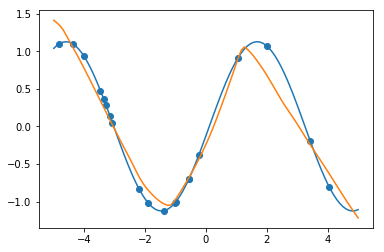

In [21]:
a = np.random.uniform(0.1, 5)
b = np.random.uniform(0, 2*np.pi)
X_train = np.random.uniform(-5,5, size=(20,1))
Y_train = a * np.sin(X_train + b)
Y_val = a * np.sin(X_val + b)
feed_dict = {
    x_train: X_train,
    x_val: X_val,
    y_train: Y_train,
    y_val: Y_val,
    lr1: 1e-4,
    lr2:1e-3
}
grad, w0, y = sess.run([grads_col, new_weights[0], hidden], feed_dict=feed_dict)
plt.scatter(X_train, Y_train)
plt.plot(X_val, Y_val)
plt.plot(X_val, y)
plt.show()